# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка.

**Нужно разобраться, влияет ли `семейное положение` и `количество детей клиента` на `факт погашения кредита в срок`.**

Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Общая информация

In [4]:
import pandas as pd

data = pd.read_csv('data.csv')
data[10:15]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
10,2,-4171.483647,36,высшее,0,женат / замужем,0,M,компаньон,0,113943.491460,покупка недвижимости
11,0,-792.701887,40,среднее,1,женат / замужем,0,F,сотрудник,0,77069.234271,покупка коммерческой недвижимости
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
13,0,-1846.641941,54,неоконченное высшее,2,женат / замужем,0,F,сотрудник,0,130458.228857,приобретение автомобиля
14,0,-1844.956182,56,высшее,0,гражданский брак,1,F,компаньон,1,165127.911772,покупка жилой недвижимости


Некоторые названия столбцов неауктуальные / непонятные.

### Переименуем столбцы 

• `dob_years` в `age` (более понятное обозначение возраста)
• `debt` в `debt_bool` (содержит булевые значения)
• `total_income` в `monthly_income` (точнее отражает описание данных)

In [3]:
data = data.rename(columns={'dob_years': 'age', 'debt': 'debt_bool', 'total_income': 'monthly_income',})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
age                 21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt_bool           21525 non-null int64
monthly_income      19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


В таблице двенадцать столбцов.  
Согласно документации к данным с учётом исправленных названий столбцов:  

* `children` — количество детей в семье (int64);
* `days_employed` — общий трудовой стаж в днях (float64);  
* `age` — возраст клиента в годах (int64);
* `education` — уровень образования клиента (object);
* `education_id` — идентификатор уровня образования (int64);
* `family_status` — семейное положение (object);
* `family_status_id` — идентификатор семейного положения (int64);
* `gender` — пол клиента (object);
* `income_type` — тип занятости (object);
* `debt_bool` — имел ли задолженность по возврату кредитов (int64);
* `monthly_income` — ежемесячный доход (float64);
* `purpose` — цель получения кредита (object).

Основные столбцы для работы: `children`, `family_status`, `debt_bool`.

Количество значений в столбцах различается. Значит, в данных есть пропущенные значения.

***
**Вывод**

* В каждой строке таблицы — данные о одном заёмщике.
* В колонке `days_employed` есть пропуски и отрицательные значения.  
    Для простоты восприятия стоит округлить значения до целых.
* Две категории заданы с индетификаторами: `family_status` и `education`.
* В столбце `education` названия категорий нужно привести к единому строчному виду.
* В столбце `children` есть ошибочные значения «20» и «-1».
* Столбец `gender` содержит одну строку с данными «XNA».  
    Можно пренебречь этой строкой.
* В колонке `monthly_income` есть пропуски.  
    Для простоты восприятия стоит округлить значения до целых.<br><br>
***

## Предобработка данных

### Обработка пропусков

In [4]:
display(data.isna().sum())
ratio_na = data['days_employed'].isna().sum() / len(data)
print('Процент пропусков: {:.0%}'.format(ratio_na))

children               0
days_employed       2174
age                    0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt_bool              0
monthly_income      2174
purpose                0
dtype: int64

Процент пропусков: 10%


* **Обработка пропусков в столбце `monthly_income`.<br>**
   Сгруппируем данные по типу занятости (`income_type`), а после заполним ежемесячный доход (`monthly_income`) медианным значением каждой группы.<br>

In [5]:
group = data.groupby(['income_type'])
data['monthly_income'] = group.monthly_income.apply(lambda x: x.fillna(x.median()))
nan = data['monthly_income'].isna().sum()
if not nan:
    print('Пропусков в стобце `monthly_income` не осталось')
else:
    print('Всё ещё остались пропуски в стобце `monthly_income`:', nan)

Пропусков в стобце `monthly_income` не осталось


* **Подготовка данных в столбце `days_employed`.<br>**
   Заменим отрицательные значения на положительные.<br>

In [6]:
data['days_employed'] = abs(data['days_employed'])
data[10:15]

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_bool,monthly_income,purpose
10,2,4171.483647,36,высшее,0,женат / замужем,0,M,компаньон,0,113943.491460,покупка недвижимости
11,0,792.701887,40,среднее,1,женат / замужем,0,F,сотрудник,0,77069.234271,покупка коммерческой недвижимости
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
13,0,1846.641941,54,неоконченное высшее,2,женат / замужем,0,F,сотрудник,0,130458.228857,приобретение автомобиля
14,0,1844.956182,56,высшее,0,гражданский брак,1,F,компаньон,1,165127.911772,покупка жилой недвижимости


* **Заменим ошибочные данные в столбце возраста клиентов (`age` = 0).<br>**
   Заменим на среднее значение перед тем как аналогичным методом запонить пропуски в столбце `days_employed` с привязкой к `age`.<br>

In [7]:
mean_age = int(data[data['age'] != 0]['age'].mean())
print('Средний возраст клиентов без учёта ошибочных данных: {}.'.format(mean_age))

Средний возраст клиентов без учёта ошибочных данных: 43.


Проверим, осталась ли ошибка с возрастом:

In [8]:
data['age'] = data['age'].replace(0, mean_age)
wrong_age = data[data['age'] == 0]['debt_bool'].count()
if not wrong_age:
    print('Ошибка (`age` = 0) исправлена.')
else:
    print(f'Всё ещё остались ошибочные (`age` = 0) данные: {wrong_age} записей.')

Ошибка (`age` = 0) исправлена.


* **Обработка пропусков в столбце `days_employed`.<br>**
   Сгруппируем данные по возрасту клиента (`age`), а после заполним трудовой стаж (`days_employed`) медианным значением каждой группы.<br>

In [9]:
group = data.groupby(['age'])
data['days_employed'] = group.days_employed.apply(lambda x: x.fillna(x.median()))
nan = data['days_employed'].isna().sum()
if not nan:
    print('Пропусков в стобце `days_employed` не осталось')
else:
    print('Всё ещё остались пропуски в стобце `days_employed`:', nan)

Пропусков в стобце `days_employed` не осталось


Проверим результат

In [10]:
display(data.isna().sum())
ratio_na = data['days_employed'].isna().sum() / len(data)
print('Процент пропусков: {:.0%}'.format(ratio_na))

children            0
days_employed       0
age                 0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt_bool           0
monthly_income      0
purpose             0
dtype: int64

Процент пропусков: 0%


In [11]:
data[10:15]

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_bool,monthly_income,purpose
10,2,4171.483647,36,высшее,0,женат / замужем,0,M,компаньон,0,113943.491460,покупка недвижимости
11,0,792.701887,40,среднее,1,женат / замужем,0,F,сотрудник,0,77069.234271,покупка коммерческой недвижимости
12,0,357103.967291,65,среднее,1,гражданский брак,1,M,пенсионер,0,118514.486412,сыграть свадьбу
13,0,1846.641941,54,неоконченное высшее,2,женат / замужем,0,F,сотрудник,0,130458.228857,приобретение автомобиля
14,0,1844.956182,56,высшее,0,гражданский брак,1,F,компаньон,1,165127.911772,покупка жилой недвижимости


***
**Вывод**

В столбцах `days_employed` и `total_income` было исправлено 4348 пропуска (10% строк).  
У всех пропущенных значений `days_employed` пропущены значения `total_income`.  
Возможно, пропуски связаны с человеческим фактором.  
При этом все другие данные заполнены.<br><br>
***

### Обработка опечаток

* **Столбец `children`.<br>**
    Заменим «20» на «2», «-1» на «1».

In [12]:
data['children'] = data['children'].replace(20, 2)
data['children'] = data['children'].replace(-1, 1)
print(f'Проверим замену опечаток в столбце `children`, отобрав уникальные значения')
data['children'].unique()

Проверим замену опечаток в столбце `children`, отобрав уникальные значения


array([1, 0, 3, 2, 4, 5])

* **Столбец `days_employed`.<br>**
    Содержал отрицательные значения.  
    Построим график зависимости трудового стажа от возраста.  

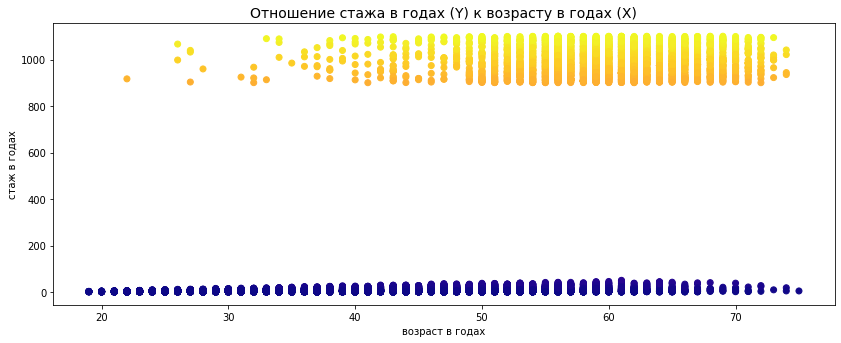

In [13]:
import matplotlib.pyplot as plt
 
gridsize = (3, 1)
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)

ax1.set_title('Отношение стажа в годах (Y) к возрасту в годах (X)', fontsize=14)
 
sctr = ax1.scatter(x=data['age'], y=data['days_employed']/365, c=data['days_employed'], cmap='plasma')
ax1.set_xlabel('возраст в годах')
ax1.set_ylabel('стаж в годах')

plt.show()

Из распределения стажа по отношению к возрасту становится ясно, что как минимум часть данных записана ошибочно.  
Стаж более 800 лет невозможен.  
Уберём эти данные и построим ещё раз.  

In [14]:
def fix_days_employed(row):
    days_employed = row['days_employed']
    if days_employed > 292000:
        return 0
    return days_employed

In [15]:
fixed_data = data.copy()
fixed_data['days_employed'] = fixed_data.apply(fix_days_employed, axis=1)

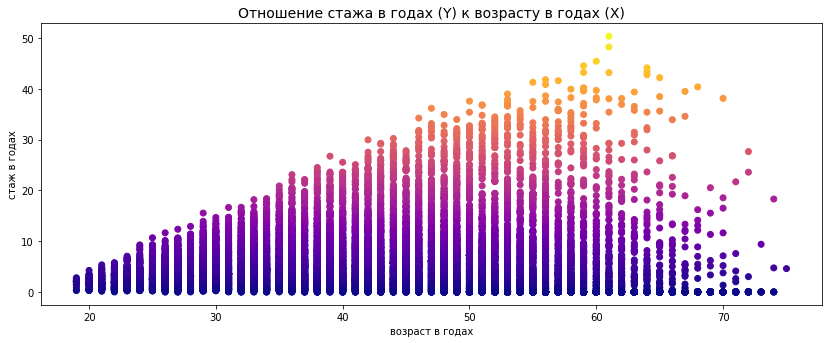

In [16]:
gridsize = (3, 1)
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_title('Отношение стажа в годах (Y) к возрасту в годах (X)', fontsize=14)
ax1.set_xlabel('возраст в годах')
ax1.set_ylabel('стаж в годах')
sctr = ax1.scatter(x=fixed_data['age'], y=fixed_data['days_employed']/365, c=fixed_data['days_employed']/365, cmap='plasma')
plt.show()

По логике, отношение стажа в годах (Y) к возрасту в годах (X) должно быть линейным.  
Странным кажется наличие множества заёмщиков со стажем до 10 лет вне зависимости от возраста.  
Пример ожидаемого отношения стажа в годах (Y) к возрасту в годах (X):  

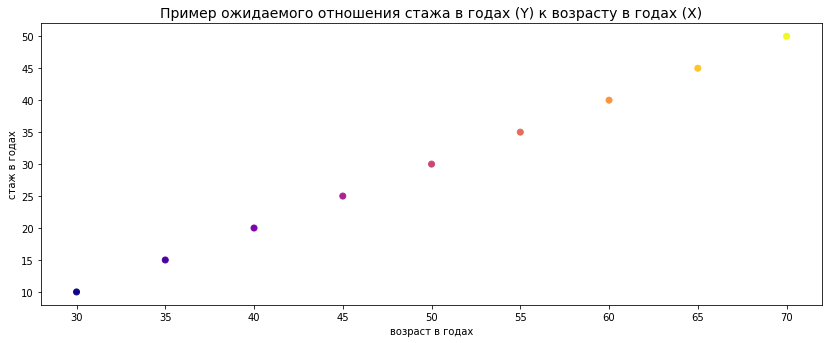

In [17]:
gridsize = (3, 1)
fig = plt.figure(figsize=(14, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
ax1.set_title('Пример ожидаемого отношения стажа в годах (Y) к возрасту в годах (X)', fontsize=14)
ax1.set_xlabel('возраст в годах')
ax1.set_ylabel('стаж в годах')
sctr = ax1.scatter(x=[30, 35, 40, 45, 50, 55, 60, 65, 70], y=[10, 15, 20, 25, 30, 35, 40, 45, 50], c=[10, 15, 20, 25, 30, 35, 40, 45, 50], cmap='plasma')
plt.show()

Проверим, нет ли зависимости между типом занятости и ошибочными данными по стажу работы.

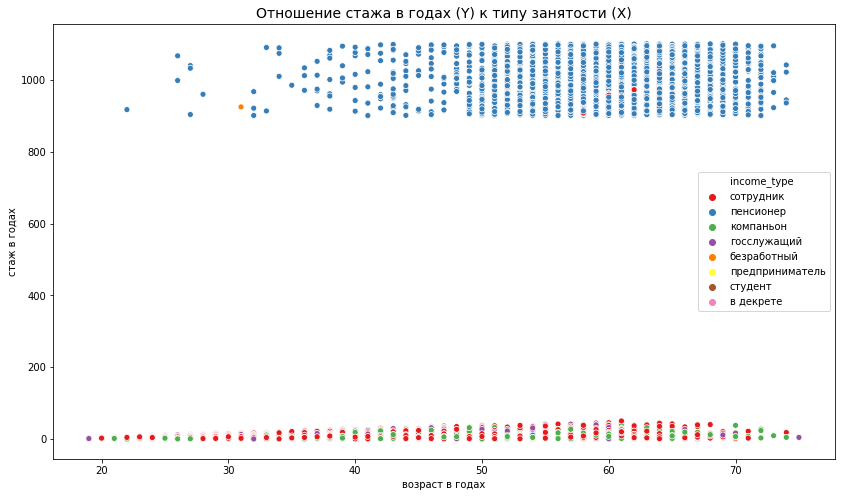

In [18]:
import seaborn as sns
fig = plt.figure(figsize=(14, 8))
ax1 = sns.scatterplot(x=data['age'], y=data['days_employed']/365, hue=data['income_type'], palette='Set1')
ax1.set_title('Отношение стажа в годах (Y) к типу занятости (X)', fontsize=14)
ax1.set_xlabel('возраст в годах')
ax1.set_ylabel('стаж в годах')
plt.show()

Из графика видно, что проблемные данные в категории «пенсионер».  
Проверим распределение у исправленных данных.  

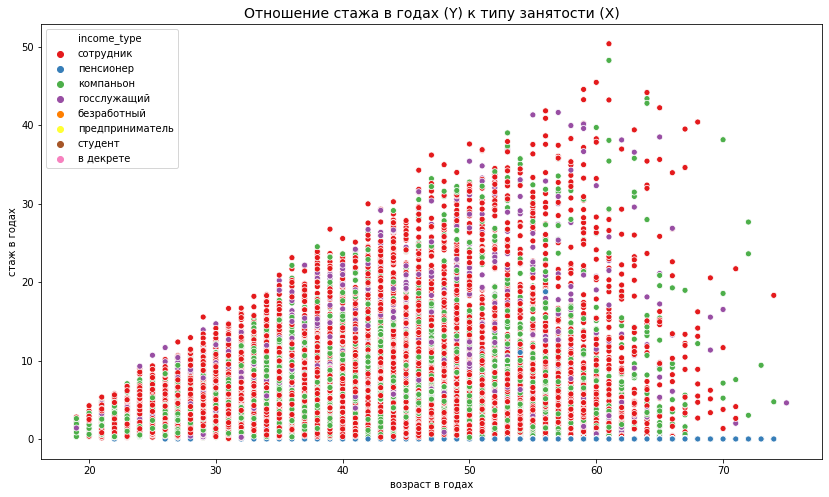

In [19]:
fig = plt.figure(figsize=(14, 8))
ax1 = sns.scatterplot(x=fixed_data['age'], y=fixed_data['days_employed']/365, hue=fixed_data['income_type'], palette='Set1')
ax1.set_title('Отношение стажа в годах (Y) к типу занятости (X)', fontsize=14)
ax1.set_xlabel('возраст в годах')
ax1.set_ylabel('стаж в годах')
plt.show()

Видим, что даже в исправленных данных нет ожидаемой линейной зависимости стажа от возраста ни в одной категории.<br>

***
**Вывод**

Не удалось выявить логику нарушения данных в столбце.  
Высокая вероятность, что данные в столбце `days_employed` искажены безвозвратно.  
Эти данные не требуются для задач данного проекта.  
Поэтому можно пренебречь ими.<br><br>
***

### Замена типа данных

* **Столбец `total_income`.<br>**
    Заменим float64 на int64.

In [20]:
data['monthly_income'] = data['monthly_income'].astype('int')

* **Столбец `days_employed`.<br>**
    Заменим float64 на int64.

In [21]:
data['days_employed'] = data['days_employed'].astype('int')

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
age                 21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt_bool           21525 non-null int64
monthly_income      21525 non-null int64
purpose             21525 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


***
**Вывод**

После правок все данные соответствуют типу<br><br>
***

### Обработка дубликатов

Приведём значения столбцов `education` к единому виду.

In [23]:
data['education'] = data['education'].str.lower()
data['education'].unique()

array(['высшее', 'среднее', 'неоконченное высшее', 'начальное',
       'ученая степень'], dtype=object)

***
**Вывод**

В категориях привели все записи к одному виду.  
Дубликаты в столбце `education` могли появится из-за человеческого фактора.<br><br>
***

### Лемматизация

In [24]:
import json
from pymystem3 import Mystem
from collections import Counter
m = Mystem()

In [25]:
def lemma_purpose(purpose):
    lemma = ' ' .join(m.lemmatize(purpose))
    return lemma[:-2]

Выделим ключевые слова в «цели кредита» с помощью метода `lemma_purpose`

In [26]:
data['words_in_purpose'] = data['purpose'].apply(lemma_purpose)

In [27]:
data['words_in_purpose'].unique()

array(['покупка   жилье', 'приобретение   автомобиль',
       'дополнительный   образование', 'сыграть   свадьба',
       'операция   с   жилье', 'образование', 'на   проведение   свадьба',
       'покупка   жилье   для   семья', 'покупка   недвижимость',
       'покупка   коммерческий   недвижимость',
       'покупка   жилой   недвижимость',
       'строительство   собственный   недвижимость', 'недвижимость',
       'строительство   недвижимость',
       'на   покупка   подержать   автомобиль',
       'на   покупка   свой   автомобиль',
       'операция   с   коммерческий   недвижимость',
       'строительство   жилой   недвижимость', 'жилье',
       'операция   со   свой   недвижимость', 'автомобиль',
       'заниматься   образование',
       'сделка   с   подержанный   автомобиль', 'получение   образование',
       'свадьба', 'получение   дополнительный   образование',
       'покупка   свой   жилье', 'операция   с   недвижимость',
       'получение   высокий   образование', 'свой  

***
**Вывод**

Данные можно сгруппировать в пять категорий.<br><br>
***

### Категоризация данных

In [28]:
def purpose_category(category_list):
    if 'автомобиль' in category_list:
        return "автомобиль"
    if "образование" in category_list:
        return "образование"
    if "свадьба" in category_list:
        return "свадьба"
    if "строительство" in category_list:
        return "строительство"
    if "недвижимость" in category_list:
        return "недвижимость"
    if "жилье" in category_list:
        return "недвижимость"

Разобьём цели получения кредита на 5 категорий:  
«автомобиль», «образование», «свадьба», «строительство», «недвижимость».  

In [29]:
data['purpose_category'] = data['words_in_purpose'].apply(purpose_category)
data.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_bool,monthly_income,purpose,words_in_purpose,purpose_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье,недвижимость
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль,автомобиль
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье,недвижимость
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование,образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба,свадьба


***
**Вывод**

Данные очищены, подготовлены и сгруппированы.  
Теперь можно перейти к решению поставленных задач.<br><br>
***

## Ответы на вопросы заказчика

### Есть ли зависимость между наличием детей и возвратом кредита в срок?

- Количественные данные:

In [30]:
mean_general = data['debt_bool'].sum() / data['debt_bool'].count()
print("В среднем процент кредитов, по которым были просроченные платежи: {0:.2f}%".format(mean_general*100))
data_pivot_children = data.pivot_table(index=['debt_bool'], columns='children', values = 'family_status_id', aggfunc='count')
data_pivot_children = data_pivot_children.fillna(0)

debt_data = {}
for i in data_pivot_children.columns:
    debt_data[i] = data_pivot_children[i][1] / data_pivot_children[i].sum()

В среднем процент кредитов, по которым были просроченные платежи: 8.09%


- Зависимость между наличием детей и возвратом кредита:

In [31]:
def debt_percentage(x): return '{:.2%} '.format(x.mean())

data.groupby('children')['debt_bool'].agg([debt_percentage])

children,debt_percentage
0,7.51%
1,9.15%
2,9.48%
3,8.18%
4,9.76%
5,0.00%


In [32]:
kids_factor = abs(data_pivot_children[0][1] / (data_pivot_children[0][0] + data_pivot_children[0][1]) - (data_pivot_children.loc[1,1:].sum() / data_pivot_children.loc[:,1:].sum().sum()))

***
**Вывод**

Люди без детей реже имеют задолженность во возврату кредитов.

In [33]:
if kids_factor < 0.01:
    print('Появление детей оказывает незначительное влияние на возврат кредита.')
else:
    print('Появление детей оказывает значительное влияние на возврат кредита.')
print('Разница между заёмщиками с детьми и без, которые имели и не имели задолженность:\n{:.2%}'.format(kids_factor))

Появление детей оказывает значительное влияние на возврат кредита.
Разница между заёмщиками с детьми и без, которые имели и не имели задолженность:
1.68%


***

### Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [34]:
data_pivot_family = data.pivot_table(index=['debt_bool'], columns='family_status', values = 'family_status_id', aggfunc='count')

debt_data = {}
for i in data_pivot_family.columns:
    debt_data[i] = data_pivot_family[i][1] / data_pivot_family[i].sum()

interim_data = {
    'family_status': list(debt_data.keys()), 
    'debt_float': list(debt_data.values())
}
df_family_status = pd.DataFrame(data=interim_data)
df_family_status['debt_percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_family_status['debt_float']], index = df_family_status.index)

df_family_status = df_family_status.sort_values(by='debt_float', ascending=False)
df_family_status[['family_status', 'debt_percentage']].style.hide_index()

family_status,debt_percentage
Не женат / не замужем,9.74%
гражданский брак,9.29%
женат / замужем,7.52%
в разводе,7.11%
вдовец / вдова,6.56%


***
**Вывод**

Неженатые и проживающие в гражданском браке люди чаще имеют задолженность по возврату кредита.<br><br>
***

### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Сгруппируем данные по уровню дохода в 6 категорий:
- Доход до 50 тыс. руб. / мес.
- Доход 50–100 тыс. руб. / мес.
- Доход 100–150 тыс. руб. / мес.
- Доход 150–200 тыс. руб. / мес.
- Доход 200–250 тыс. руб. / мес.
- Доход более 250 тыс. руб. / мес.


In [35]:
def income_category(row):
    income = row['monthly_income']
    if income <= 50000:
        return 'Доход до 50 тр'
    if 50000 < income <= 100000:
        return 'Доход 50–100 тр'
    if 100000 < income <= 150000:
        return 'Доход 100–150 тр'
    if 150000 < income <= 200000:
        return 'Доход 150–200 тр'
    if 200000 < income <= 250000:
        return 'Доход 200–250 тр'
    if 250000 < income:
        return 'Доход более 250 тр'

In [36]:
data['income_category'] = data.apply(income_category, axis=1)
data.head()

,children,days_employed,age,education,education_id,family_status,family_status_id,gender,income_type,debt_bool,monthly_income,purpose,words_in_purpose,purpose_category,income_category
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,покупка жилье,недвижимость,Доход более 250 тр
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,приобретение автомобиль,автомобиль,Доход 100–150 тр
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,покупка жилье,недвижимость,Доход 100–150 тр
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,дополнительный образование,образование,Доход более 250 тр
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,сыграть свадьба,свадьба,Доход 150–200 тр


In [37]:
data_pivot_income = data.pivot_table(index=['debt_bool'], columns='income_category', values = 'family_status_id', aggfunc='count')

debt_data = {}
for i in data_pivot_income.columns:
    debt_data[i] = data_pivot_income[i][1] / data_pivot_income[i].sum()

interim_data = {
    'income_category': list(debt_data.keys()), 
    'debt_float': list(debt_data.values())
}
df_income_status = pd.DataFrame(data=interim_data)
df_income_status['debt_percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_income_status['debt_float']], index = df_income_status.index)

df_income_status = df_income_status.sort_values(by='debt_float', ascending=False)
df_income_status[['income_category', 'debt_percentage']].style.hide_index()

income_category,debt_percentage
Доход 100–150 тр,8.64%
Доход 150–200 тр,8.49%
Доход 50–100 тр,8.09%
Доход 200–250 тр,7.28%
Доход более 250 тр,6.90%
Доход до 50 тр,6.18%


***
**Вывод**

Судя по данным, люди с наименьшим и наибольшим доходом чаще остальных категорий выплачивают кредит в срок.<br><br>
***

### Как разные цели кредита влияют на его возврат в срок?

In [38]:
data_pivot_purpose = data.pivot_table(index=['debt_bool'], columns='purpose_category', values = 'family_status_id', aggfunc='count')

debt_data = {}
for i in data_pivot_purpose.columns:
    debt_data[i] = data_pivot_purpose[i][1] / data_pivot_purpose[i].sum()

interim_data = {
    'purpose_category': list(debt_data.keys()), 
    'debt_float': list(debt_data.values())
}
df_purpose_status = pd.DataFrame(data=interim_data)
df_purpose_status['debt_percentage'] = pd.Series(["{0:.2f}%".format(val * 100) for val in df_purpose_status['debt_float']], index = df_purpose_status.index)

df_purpose_status = df_purpose_status.sort_values(by='debt_float', ascending=False)
df_purpose_status[['purpose_category', 'debt_percentage']].style.hide_index()

purpose_category,debt_percentage
автомобиль,9.34%
образование,9.20%
свадьба,7.92%
строительство,7.66%
недвижимость,7.12%


***
**Вывод**

Клиенты чаще выплачивают кредит в срок, если деньги взяты на покупку / строительство недвижимости или на свадьбу.<br><br>
***

## Общий вывод

Первоначальные данные были подготовлены к анализу:
- Переименованы столбцы
- Заполнены пропуски значений
- Данные приведены к подходящему для анализа типу
- Все дубликаты обработаны
- Данные сгруппированы по категориям цели кредита, уровню дохода

В среднем процент кредитов, по которым были просроченные платежи — 8.09%

Можно выделить следующие экстремумы в каждой группе:

<b>Цель кредита</b>  
- Наиболее надёжная группа заёмщиков:  
   Люди, берущие кредит на операции с недвижимостью.  
   Процент наличия просроченных платежей в данной группе — 7,12%  
- Наименее надёжная группа заёмщиков:  
   Люди, берущие кредит на покупку автомобиля  
   Процент наличия просроченных платежей в данной группе — 9,34%  

<b>Уровень дохода</b>  
- Наиболее надёжная группа заёмщиков:  
   Люди с наименьшим и наибольшим доходом.  
   Процент наличия просроченных платежей в данной группе — 6,18% / 6,90%
- Наименее надёжная группа заёмщиков:  
   Люди со средним доходом.  
   Процент наличия просроченных платежей в данной группе — 8,64%  

<b>Семейное положение</b>  
- Наиболее надёжная группа заёмщиков:  
   Овдовевшие люди.  
   Процент наличия просроченных платежей в данной группе — 6,56%  
- Наименее надёжная группа заёмщиков:  
   Одинокие люди, которые никогда не были женаты / замужем.  
   Процент наличия просроченных платежей в данной группе — 9,74%  

<b>Наличие детей</b>  
- Наиболее надёжная группа заёмщиков:  
   Люди, у которых нет детей.  
   Процент наличия просроченных платежей в данной группе — 7.51%  
   Клиенты, у которых пять детей, ни разу не выплачивали кредит с опозданием,  
   но не включены в основной вывод из-за небольшой численности (0,04%).  
- Наименее надёжная группа заёмщиков:  
   Клиенты, у которых появляется ребёнок, вылачивают кредит не в срок чаще на 1,68%.  